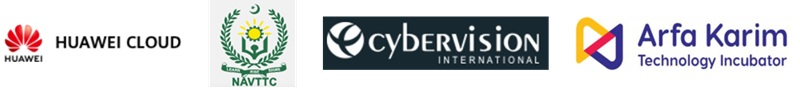

---

# **Huawei Cloud AI Training Day 31 - Part B**


# Vanilla MLP on CIFAR-10 (Version 2)

### Standardization after normalization → steadier training.

### Bigger network but with L2 weight decay + Dropout 0.2 → capacity without overfitting too hard.

### BatchNorm before ReLU → faster, more stable convergence.

### LR scheduler (ReduceLROnPlateau) → automatic LR tuning.

### EarlyStopping (+ checkpoint) → train longer safely and keep the best weights.

In [ ]:
import os, random, numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from sklearn.metrics import classification_report

In [ ]:
# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

In [ ]:
# 1) Load CIFAR-10
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()
y_train = y_train.squeeze();
y_test = y_test.squeeze()

In [ ]:
# 2) Normalize + Standardize
# scale to [0,1]
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32")  / 255.0

# per-channel standardization using train stats
mean = x_train.mean(axis=(0,1,2), keepdims=True)
std  = x_train.std(axis=(0,1,2), keepdims=True) + 1e-7
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

# flatten for MLP
x_train = x_train.reshape(len(x_train), -1)
x_test  = x_test.reshape(len(x_test),  -1)

num_classes = 10
input_dim = x_train.shape[1]  # 3072

In [ ]:
# 3) Build a stronger, regularized MLP
def build_mlp(input_dim, num_classes, l2=1e-4, drop=0.2):
    reg = regularizers.l2(l2)

    def block(x, units, drop):
        x = layers.Dense(units, use_bias=False, kernel_regularizer=reg)(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.Dropout(drop)(x)
        return x

    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    x = block(x, 1536, drop)  # larger first layer
    x = block(x, 768,  drop)
    x = block(x, 384,  drop)
    x = block(x, 192,  drop)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

model = build_mlp(input_dim, num_classes, l2=1e-4, drop=0.2)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1536)           │     4,718,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1536)           │         6,144 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1536)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 768)            │     1,179,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 768)            │         3,072 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │       294,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 192)            │        73,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 192)            │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │         1,930 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,280,330 (23.96 MB)

 Trainable params: 6,274,570 (23.94 MB)

 Non-trainable params: 5,760 (22.50 KB)

In [ ]:
# 4) Callbacks: Early Stop, Reduce LR, Best Checkpoint
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=8, restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_accuracy", factor=0.5, patience=3, min_lr=1e-6, verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        "best_mlp.keras", monitor="val_accuracy", save_best_only=True, verbose=1
    )
]

In [ ]:
# 5) Train longer (early stopping will cap it)
history = model.fit(
    x_train, y_train,
    validation_split=0.1,
    epochs=60,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.3058 - loss: 2.3597
Epoch 1: val_accuracy improved from -inf to 0.41680, saving model to best_mlp.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 62s 321ms/step - accuracy: 0.3061 - loss: 2.3587 - val_accuracy: 0.4168 - val_loss: 2.0470 - learning_rate: 0.0010
Epoch 2/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.4314 - loss: 1.9526
Epoch 2: val_accuracy improved from 0.41680 to 0.47320, saving model to best_mlp.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 77s 294ms/step - accuracy: 0.4315 - loss: 1.9523 - val_accuracy: 0.4732 - val_loss: 1.8402 - learning_rate: 0.0010
Epoch 3/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.4834 - loss: 1.8032
Epoch 3: val_accuracy improved from 0.47320 to 0.50340, saving model to best_mlp.keras
176/176 ━━━━━━━━━━━━━━━━━━━━ 49s 281ms/step - accuracy: 0.4834 - loss: 1.8031 - val_accuracy: 0.5034 - val_loss: 1.7303 - learning_rate: 0.0010
Epoch 4/60
176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 256

In [ ]:
# 6) Evaluate
test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print(f"\n[Improved MLP] Test accuracy: {test_acc:.4f}")

# Classification report
y_prob = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)
print("\n[Improved MLP] Classification report:")
print(classification_report(y_test, y_pred, digits=4))

In [ ]:
# 7) Save final model (best also saved via checkpoint)
#os.makedirs("saved_models", exist_ok=True)
#model.save("saved_models/mlp_cifar10_improved.keras")
#print("\nSaved current model to saved_models/mlp_cifar10_improved.keras")
#print("Best checkpoint (by val_accuracy): best_mlp.keras")